In [1]:
# # Standard imports
import random
import pandas as pd
import numpy as np

# # Own Model import
from lib.fl_model_v9 import *
import lib
# # import lib.fl_model_v5 as flm

# # for natural sorting
import re

# #for nondominated sorting
import lib.pareto as pareto
# # from lib.list_imports import find_loaded_modules

# # for parallel plotting
from lib.parallel_plotting import plot_optimal

# # For checking ema running time
import time

import importlib

import geopy
from geopy.distance import great_circle 


In [2]:
import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [4]:
find_loaded_modules().HTML

Name,Version,Path,SHA
ema_workbench,1.1.3,,
geopy,1.13.0,,
git,2.1.9,,
json,2.0.9,,
lib.pareto,1.1.1-3,,
numpy,1.14.2,,
pandas,0.23.0,,
re,2.2.1,,


In [5]:
case = "Nepal"

# FL Model test

Moved to different Notebook

# FL Model Nepal

## Nepal Data Load


In [6]:
DPs = pd.read_csv("Nepal/Prepared Input Data/DPs.csv")
# DPs.columns

FLs = pd.read_csv("Nepal/Prepared Input Data/FLs.csv")
# FLs.columns

SPs = pd.read_csv("Nepal/Prepared Input Data/SPs.csv")
# SPs.columns
Fix_Unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case), index_col=0)
Fix_Unc

,lower,best_estimate,upper
var,,,
unit_opening_costs,50.0,100,200
unit_transport_cost,0.5,1,2
FL_operations_cost,20.0,30,50
FL_range,2.0,4,6
demand_per_affected,10.0,20,50


## Nepal Instantiation 

In [7]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}
# DPpop = {"DPpop{}".format(i): random.uniform(10,100) for i in range(nr_of_DPs)}


## Create distance matrix

In [8]:
# node_names = ["SP{}".format(i) for i, ind in enumerate(SPs.index)] + [
#     "FL{}".format(i) for i, ind in enumerate(FLs.index)
# ] + ["DP{}".format(i) for i, ind in enumerate(DPs.index)]

## Disruptions

In [9]:
epicentre_name = "RealLocation"

In [10]:
disruptionsFLs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionFL{}.txt'.format(epicentre_name))
disruptionsDPs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionDP{}.txt'.format(epicentre_name))

In [12]:
# Base real values on Nepal earthquake
# DSR is abbreviation for Disruption

DSRDP = {"DSRDP{}".format(i): 1.5 for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): 1.5 for i in range(len(FLX))}

# Multi-Objective Optimisation Framework

Pseudocode:

    Current situation
    Create possible options (full factorial)
    Evaluate all possible options
    Check pareto front of outcomes

## Optimisation single period 

In [13]:
start_situation = {key:0 for key in FLs.Name}

In [14]:
from itertools import product

In [15]:
permutations = [i for i in product([0,1],repeat=len(FLs)) if sum(i) ==4]

In [16]:
len(permutations)

4845

In [17]:
All_optional_pols = []

for p in permutations:
    tmp = {"FLO{}".format(i):val for i,val in enumerate(p)}
    All_optional_pols.append(tmp)

In [18]:
len(All_optional_pols)

4845

## policies: FLs one for one

In [19]:
# %%timeit
# Evaluate all optional policies with best estimate values
best_est_results_opt_pols = []
for policy in All_optional_pols:
    best_est_results_opt_pols.append(
        FL_model(
            unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
            FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))

In [20]:
best_est_results_opt_pols

[(37716.18227374999, 23, 14545.01999999999, 47553.149999999994, False, None),
 (71773.25756958332, 22, 11637.689999999988, 47553.149999999994, False, None),
 (74380.84978333335, 21, 11627.689999999988, 48298.95, False, None),
 (71017.81070083335, 21, 11627.689999999988, 47553.149999999994, True, None),
 (63195.76956541667, 22, 11941.499999999989, 88283.85, False, None),
 (36587.904050833335, 24, 14555.01999999999, 47192.7, False, None),
 (37263.573863749996, 23, 14545.01999999999, 47192.7, False, None),
 (36225.138743749994, 23, 14545.01999999999, 47192.7, True, None),
 (28403.09760833334, 24, 14858.82999999999, 88283.85, False, None),
 (71177.24156916667, 22, 11637.689999999988, 47192.7, False, None),
 (70138.80644916669, 22, 11637.689999999988, 47192.7, True, None),
 (62316.76531375, 23, 11951.499999999989, 88283.85, False, None),
 (70814.47626208332, 21, 11627.689999999988, 47192.7, True, None),
 (62992.43512666666, 22, 11941.499999999989, 88283.85, False, None),
 (61954.00000666667

## Original from here

In [21]:
# outcome indicators, as internally used by the model
oois = [
    'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_travel_time'
]
# Put outcomes in DF

df_best_est_results_opt_pols = pd.DataFrame(
    np.asarray(best_est_results_opt_pols)[:, :5],
    columns=oois + ["constraint"])
df_best_est_results_opt_pols.tail()

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_travel_time,constraint
4840,215683,11,6370.05,35118.1,True
4841,142886,17,9809.45,51417.6,False
4842,142886,17,9809.45,44466.1,False
4843,142886,17,9809.45,51417.6,False
4844,124757,17,9809.45,51417.6,True


In [22]:
# constraint
df_best_est_results_opt_pols = df_best_est_results_opt_pols[df_best_est_results_opt_pols.constraint == 1]

df_best_est_results_opt_pols = df_best_est_results_opt_pols[oois]

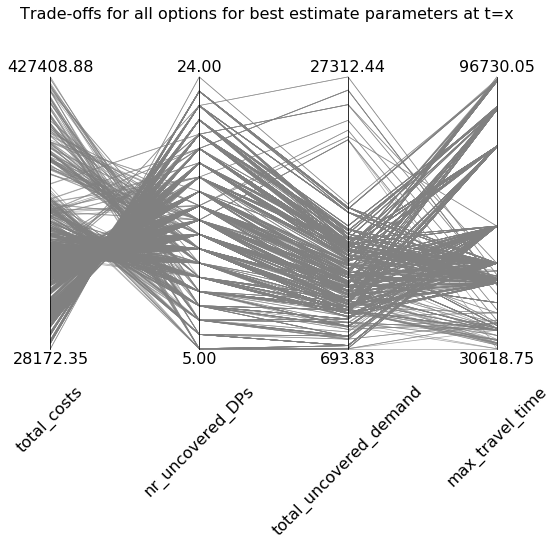

In [23]:
title = "Trade-offs for all options for best estimate parameters at t=x"
plot_optimal(df_best_est_results_opt_pols, oois, title)

In [24]:
# options for pareto sorting# minimising is default
kwargs = {"maximize_all": True}
kwargs2 = {"maximize": [0, 1]}

nondominated_BE_policy_results = np.array(pareto.eps_sort(
    [list(df_best_est_results_opt_pols.itertuples(index=True))], [1, 2, 3, 4],
    [1e-9, 1e-9, 1e-9, 1e-9]))

#Filter out those where new demand is covered
# nondominated_BE_policy_results = nondominated_BE_policy_results[nondominated_BE_policy_results[:,4] != 0]

# Put outcomes in DF
df_nondominated_BE_policy_results = pd.DataFrame(
    np.asarray(nondominated_BE_policy_results),
    columns=["pol_i"] + oois).set_index("pol_i")
df_nondominated_BE_policy_results.head(5)

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_travel_time
pol_i,,,,
12.0,70814.476262,21.0,11627.69,47192.70
42.0,166859.755641,12.0,4993.83,46617.15
48.0,129742.479721,14.0,7911.16,46617.15
51.0,163656.147427,13.0,5003.83,46617.15
58.0,147592.098330,12.0,6720.58,46617.15


In [25]:
df_nondominated_BE_policy_results.shape

(87, 4)

In [26]:
nondominated_BE_policy_results

array([[1.20000000e+01, 7.08144763e+04, 2.10000000e+01, 1.16276900e+04,
        4.71927000e+04],
       [4.20000000e+01, 1.66859756e+05, 1.20000000e+01, 4.99383000e+03,
        4.66171500e+04],
       [4.80000000e+01, 1.29742480e+05, 1.40000000e+01, 7.91116000e+03,
        4.66171500e+04],
       [5.10000000e+01, 1.63656147e+05, 1.30000000e+01, 5.00383000e+03,
        4.66171500e+04],
       [5.80000000e+01, 1.47592098e+05, 1.20000000e+01, 6.72058000e+03,
        4.66171500e+04],
       [9.30000000e+01, 8.54277155e+04, 1.70000000e+01, 9.54617000e+03,
        4.66171500e+04],
       [1.08000000e+02, 1.71816160e+05, 1.00000000e+01, 4.12323000e+03,
        4.66171500e+04],
       [1.20000000e+02, 3.04698481e+05, 1.00000000e+01, 3.85998000e+03,
        4.66171500e+04],
       [1.23000000e+02, 1.61353661e+05, 1.00000000e+01, 4.16379000e+03,
        7.98867000e+04],
       [3.78000000e+02, 1.63118234e+05, 1.10000000e+01, 4.43704000e+03,
        7.97788500e+04],
       [3.83000000e+02, 1.7180

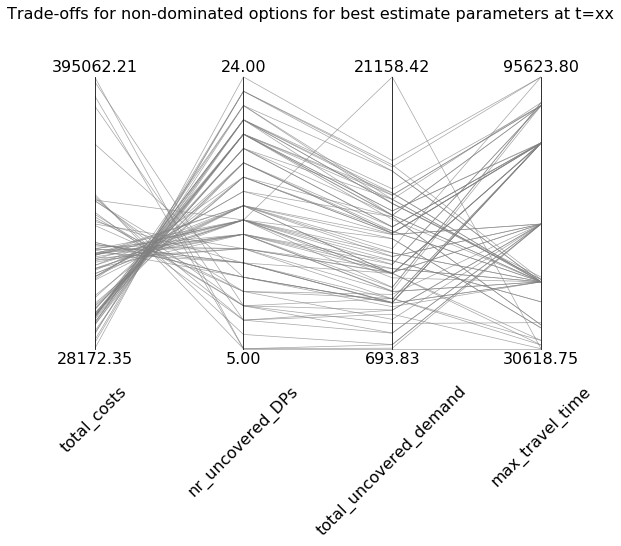

In [27]:
title = "Trade-offs for non-dominated options for best estimate parameters at t=xx"
plot_optimal(df_nondominated_BE_policy_results, oois, title)

In [28]:
# policies for all nondominated policies
nondom_i = [int(a[0]) for a in nondominated_BE_policy_results]

nondominated_BE_policies = np.array(All_optional_pols)[nondom_i]
nondominated_BE_policies.shape

(87,)

In [29]:
## If skipping robustness testing and filtering
# import pickle

# # Store data (serialize)
# with open('{}/MOO/rob_nondom_pols_test3_norobustnessfilter.pickle'.format(case),
#           'wb') as handle:
#     pickle.dump(
#         (nondominated_BE_policies),
#         handle,
#         protocol=pickle.HIGHEST_PROTOCOL)

#### visualise all nondom pols

In [30]:
all_nondom_BE_pols = {name:1 if pos_i in nondom_i else 0 for pos_i, name in enumerate(FLs['Name'])}


In [31]:
tmp = [[key for key,val in pol.items() if val == 1] for pol in np.array(All_optional_pols)[nondom_i]]

In [32]:
flat_list = [item for sublist in tmp for item in sublist]

In [33]:
set(flat_list)

{'FLO0',
 'FLO1',
 'FLO11',
 'FLO12',
 'FLO13',
 'FLO14',
 'FLO15',
 'FLO16',
 'FLO19',
 'FLO3',
 'FLO4',
 'FLO7',
 'FLO8'}

In [34]:
"This doesn't work for MOO"

# # inspect nondominated results

# all_nondom_BE_pols = {name:1 if pos_i in nondom_i else 0 for pos_i, name in enumerate(FLs['Name'])}

# a = FL_model(
#     unit_opening_costs = 1,
#     unit_transport_cost= 1, #cost per hour/ dollar or euroXX
#     FL_operations_cost = 10,
#     demand_per_affected = 1, # units per 1000 affected people
#     graphical_representation = True,
#     FL_range=4, # in hours. km? --> meters
#     dist_method="from_table", #"great_circle",
#     table_dir = "Nepal/Prepared Input Data/routing_table.csv",
#     lorry_speed="nope", #km/h? -->m/s
#     **SPX,
#     **SPY,
#     **DPX,
#     **DPY,
#     **FLX,
#     **FLY,
#     **all_nondom_BE_pols,
#     **DSRDP,
#     **DSRFL,
#     **DPpop)
# print("These are all the FLs that are in the set of non-dominated policies")
# a[5]

"This doesn't work for MOO"

# EMA Framework

## EMA instantiations

In [35]:
models = []
t = 0
model = Model("flmodelt{}".format(t), FL_model)

model.locations = [
    Constant("DPX{}".format(i), x)
    for i, x in zip(DPs.index, DPs['longitude'])
] + [
    Constant("DPY{}".format(i), y)
    for i, y in zip(DPs.index, DPs['latitude'])
] + [
    Constant("SPX{}".format(i), x)
    for i, x in zip(SPs.index, SPs['longitude_deg'])
] + [
    Constant("SPY{}".format(i), y)
    for i, y in zip(SPs.index, SPs['latitude_deg'])
] + [Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])] + [
    Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
]

# Reachability of Demand Points and Facility Locations can be disrupted
# Disruption also determines demand (disr-1)*pop
model.disruptions = [RealParameter(key,1,2) for key,val in DSRDP.items()] + [RealParameter(key,1,2) for key,val in DSRFL.items()]


model.constants = [
    Constant('graphical_representation', False),
    Constant('dist_method', 'from_table'),
    Constant('table_dir', 'Nepal/Prepared Input Data/routing_table.csv')
    #list of other constants
] + model.locations + [  # population DPs
    Constant("DPpop{}".format(i), pop)
    for i, pop in zip(DPs.index, DPs['population'])
] #+ model.disruptions


model.uncertainties = [
    RealParameter('unit_opening_costs', 
                  Fix_Unc.lower['unit_opening_costs'],
                  Fix_Unc.upper['unit_opening_costs']),
    RealParameter('unit_transport_cost',
                  Fix_Unc.lower['unit_transport_cost'],
                  Fix_Unc.upper['unit_transport_cost']),  # #cost per hour/ dollar or euroXX
    RealParameter('FL_operations_cost',
                  Fix_Unc.lower['FL_operations_cost'],
                  Fix_Unc.upper['FL_operations_cost']),
    RealParameter('FL_range',
                  Fix_Unc.lower['FL_range'],
                  Fix_Unc.upper['FL_range']),  # km TODO: great circle distance
    RealParameter('demand_per_affected',
                  Fix_Unc.lower['demand_per_affected'],
                  Fix_Unc.upper['demand_per_affected']),  #units per 1000 affected people
    #list of other uncertainties
] + model.disruptions  #+ model.locations_uncertain

model.outcomes = [
    ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome(
        "max_travel_time",
        kind=ScalarOutcome.MINIMIZE,
    )
]

models.append(model)

In [38]:
if [o.name for o in models[0].outcomes] != oois:
    print("Watch out! Oois and model outcome names are not similar!")

In [39]:
for model in models:
    print(model.name)

flmodelt0


In [40]:
nondominated_BE_policies_EMA = []
for name, pol in zip(nondom_i,nondominated_BE_policies):
    nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

In [42]:
time1 = time.time()
all_scen_results_nondom_pols = perform_experiments(model,500,nondominated_BE_policies_EMA)
time2 = time.time()
print("Total time:{}".format(time2-time1),"\n","time per run = {}".format((time2-time1)/1000))

[MainProcess/INFO] performing 500 scenarios * 87 policies * 1 model(s) = 43500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 4350 cases completed
[MainProcess/INFO] 8700 cases completed
[MainProcess/INFO] 13050 cases completed
[MainProcess/INFO] 17400 cases completed
[MainProcess/INFO] 21750 cases completed
[MainProcess/INFO] 26100 cases completed
[MainProcess/INFO] 30450 cases completed
[MainProcess/INFO] 34800 cases completed
[MainProcess/INFO] 39150 cases completed
[MainProcess/INFO] 43500 cases completed
[MainProcess/INFO] experiments finished


Total time:476.08988642692566 
 time per run = 0.4760898864269257


timelog: (3000 experiments)
1. possibly with cpu problems due to failed multiprocessing <br>
Total time:186.64591431617737 <br>
time per run = 0.18664591431617736
2. model v2 <br>
Total time:156.22968077659607  <br>
 time per run = 0.15622968077659607
3. model v2 4 policies <br>
Total time:200.71212720870972 
 time per run = 0.2007121272087097
4. 
Total time:144.36057209968567 <br>
 time per run = 0.14436057209968567
 
5. 
Total time:69.68182039260864 <br>
 time per run = 0.06968182039260865
 
6. 5000 experiments <br>
time per run = 0.03758887338638306

In [43]:
# Add parameter in filename for period t=1,2...x
ema.save_results(all_scen_results_nondom_pols,
                 "{}/MOO/candidate_policy_robustness_Full_Uncertainty.tar.gz".format(case))

[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MOO\candidate_policy_robustness_Full_Uncertainty.tar.gz


# Robustness Framework

In [44]:
all_scen_results_nondom_pols = ema.load_results(
    "{}/MOO/candidate_policy_robustness_Full_Uncertainty.tar.gz".format(case))
experiments, outcomes = all_scen_results_nondom_pols

[MainProcess/INFO] results loaded succesfully from C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MOO\candidate_policy_robustness_Full_Uncertainty.tar.gz


In [49]:
def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1: #MINIMIZE
        score = (np.mean(data)+1)*(np.std(data)+1) #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1: #MAXIMIZE
        score = (np.mean(data)+1)/(np.std(data)+1)
    return score

sigN_results = []

for policy in nondominated_BE_policies_EMA:
    #filter the outcome values corresponding to each policy using a logical index
    logical_index = experiments['policy']==int(policy.name)
    pol_outcomes = {key:outcomes[key][logical_index] for key in outcomes.keys()}
    temp_result = {}
    for ooi in models[0].outcomes:
        temp_result[ooi.name] = calculate_signalNoise(pol_outcomes[ooi.name], ooi.kind)
    sigN_results.append(temp_result)    


In [51]:
df_sigN = pd.DataFrame(sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])
df_sigN

,max_travel_time,nr_uncovered_DPs,total_costs,total_uncovered_demand
12,2.293750e+08,107.069480,1.344728e+10,1.706495e+08
42,2.985658e+08,69.967291,6.166404e+10,6.609461e+07
48,2.981258e+08,73.086358,4.486370e+10,8.794691e+07
51,2.985658e+08,68.589118,5.961754e+10,6.329985e+07
58,2.985658e+08,60.196189,5.892936e+10,5.704020e+07
93,2.924621e+08,97.449612,2.030911e+10,1.116445e+08
108,3.075146e+08,49.446839,6.469107e+10,4.327231e+07
120,3.072399e+08,80.510873,2.002619e+11,2.022758e+08
123,1.146205e+09,44.072465,5.354105e+10,4.095144e+07
378,1.143706e+09,49.205958,5.506137e+10,4.781710e+07


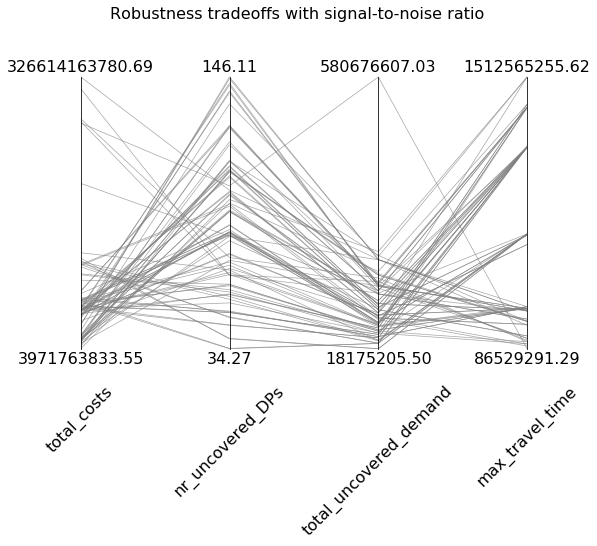

In [52]:

title = "Robustness tradeoffs with signal-to-noise ratio"
plot_optimal(df_sigN, oois, title)

In [53]:
def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    
    #determine the regret values for eaxh policy in each scenario
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])]
    
    max_regrets = np.max(regrets, axis=1)
    
    return max_regrets

In [54]:
reg_results = {}
# we need to iterate over the outcomes differently now, 
#because the maximum egret calculation requires the outcome values for all policies
for ooi in models[0].outcomes:
    data = []
    for policy in nondominated_BE_policies_EMA:
        logical_index = experiments['policy'] == int(policy.name) 
        data.append(outcomes[ooi.name][logical_index])
    reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    


In [55]:
reg_results

{'total_costs': array([ 295337.41038903,  875144.83976734,  791595.46036275,
         858349.12198828,  823833.2097455 ,  414477.44976951,
         909893.51944373, 1919633.63633518,  879556.22688585,
         830613.58584831,  845965.99024108,  826006.15646741,
        1036327.95992275, 1143044.3400395 , 1049130.0474642 ,
        1015241.35827563, 1138094.63160056, 2099574.00476256,
        1082913.14737756,  801252.46461702,  863357.76876925,
        2544375.7605439 , 1145622.79896788, 2251113.24003359,
        3410196.69702964,  811680.2891968 , 1050803.79910917,
         980510.71728685,  973940.00561882, 1109657.6160134 ,
        1071684.00078793,  298418.76708898,  198870.27784323,
         292079.98408774,  241719.78216833,  421326.14672484,
         424247.97756869,  303610.693589  ,  414600.02675625,
         262656.33685081,  300361.82808072,  836964.07734544,
         792722.05334605,  640778.36344061,  837507.04371799,
         816161.07895196,  767952.62537468,  782048.851

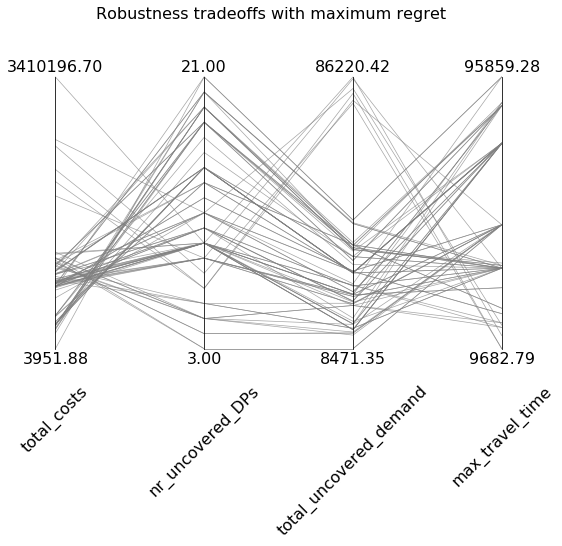

In [56]:
# we can again convert the robustness values into a dataframe. 
#However, since the results are in a dictionary, we need to do it differently.
df_regret = pd.DataFrame.from_dict(reg_results, orient='columns',)
df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]
title = "Robustness tradeoffs with maximum regret"
plot_optimal(df_regret, oois, title)

## Choose nondominated robust policies

In [57]:
df_regret

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_travel_time
12,2.953374e+05,19.0,36835.980409,36103.535186
42,8.751448e+05,10.0,20818.591744,35226.553796
48,7.915955e+05,11.0,26409.083007,35226.553796
51,8.583491e+05,10.0,16315.435335,35226.553796
58,8.238332e+05,9.0,23428.388260,35226.553796
93,4.144774e+05,14.0,30139.498246,35226.553796
108,9.098935e+05,6.0,14316.971348,35226.553796
120,1.919634e+06,9.0,85694.565392,35226.553796
123,8.795562e+05,10.0,13929.141602,74891.466313
378,8.306136e+05,10.0,15600.905184,74747.769030


In [58]:
df_sigN

,max_travel_time,nr_uncovered_DPs,total_costs,total_uncovered_demand
12,2.293750e+08,107.069480,1.344728e+10,1.706495e+08
42,2.985658e+08,69.967291,6.166404e+10,6.609461e+07
48,2.981258e+08,73.086358,4.486370e+10,8.794691e+07
51,2.985658e+08,68.589118,5.961754e+10,6.329985e+07
58,2.985658e+08,60.196189,5.892936e+10,5.704020e+07
93,2.924621e+08,97.449612,2.030911e+10,1.116445e+08
108,3.075146e+08,49.446839,6.469107e+10,4.327231e+07
120,3.072399e+08,80.510873,2.002619e+11,2.022758e+08
123,1.146205e+09,44.072465,5.354105e+10,4.095144e+07
378,1.143706e+09,49.205958,5.506137e+10,4.781710e+07


In [59]:
all_robustness_scores = pd.merge(df_regret,df_sigN, left_index=True, right_index=True, suffixes=('_regret', '_sigN'))

In [60]:
all_robustness_scores

,total_costs_regret,nr_uncovered_DPs_regret,total_uncovered_demand_regret,max_travel_time_regret,max_travel_time_sigN,nr_uncovered_DPs_sigN,total_costs_sigN,total_uncovered_demand_sigN
12,2.953374e+05,19.0,36835.980409,36103.535186,2.293750e+08,107.069480,1.344728e+10,1.706495e+08
42,8.751448e+05,10.0,20818.591744,35226.553796,2.985658e+08,69.967291,6.166404e+10,6.609461e+07
48,7.915955e+05,11.0,26409.083007,35226.553796,2.981258e+08,73.086358,4.486370e+10,8.794691e+07
51,8.583491e+05,10.0,16315.435335,35226.553796,2.985658e+08,68.589118,5.961754e+10,6.329985e+07
58,8.238332e+05,9.0,23428.388260,35226.553796,2.985658e+08,60.196189,5.892936e+10,5.704020e+07
93,4.144774e+05,14.0,30139.498246,35226.553796,2.924621e+08,97.449612,2.030911e+10,1.116445e+08
108,9.098935e+05,6.0,14316.971348,35226.553796,3.075146e+08,49.446839,6.469107e+10,4.327231e+07
120,1.919634e+06,9.0,85694.565392,35226.553796,3.072399e+08,80.510873,2.002619e+11,2.022758e+08
123,8.795562e+05,10.0,13929.141602,74891.466313,1.146205e+09,44.072465,5.354105e+10,4.095144e+07
378,8.306136e+05,10.0,15600.905184,74747.769030,1.143706e+09,49.205958,5.506137e+10,4.781710e+07


Use small epsilon value, because efficiency is not relevant (because of low numbers of alternatives, smaller epsilon is possible. larger epsilon leads to faster processing time)

In [61]:
# Non-dominated sorting for outcomes


# options for pareto sorting# minimising is default
kwargs = {"maximize_all":True}
kwargs2 = {"maximize":[0,1]}

robust_nondominated_policies = pareto.eps_sort([list(all_robustness_scores.itertuples(index=True))],[i+1 for i in range(all_robustness_scores.shape[1])], [1e-9] * all_robustness_scores.shape[1])
robust_nondominated_policies

[['12',
  295337.4103890344,
  19.0,
  36835.98040865938,
  36103.53518600916,
  229375001.78358668,
  107.06948018063741,
  13447278272.490326,
  170649454.5430834],
 ['48',
  791595.4603627478,
  11.0,
  26409.0830065393,
  35226.55379571946,
  298125765.10723734,
  73.0863584667847,
  44863697106.24877,
  87946911.54766013],
 ['51',
  858349.1219882814,
  10.0,
  16315.43533485604,
  35226.55379571946,
  298565785.6667465,
  68.58911785700901,
  59617539842.87493,
  63299852.707123905],
 ['58',
  823833.2097454951,
  9.0,
  23428.388260438078,
  35226.55379571946,
  298565785.6667465,
  60.196189004933,
  58929355709.0628,
  57040201.03703154],
 ['93',
  414477.4497695138,
  14.0,
  30139.49824573795,
  35226.55379571946,
  292462121.7444959,
  97.44961181839932,
  20309111852.668518,
  111644456.81231977],
 ['108',
  909893.5194437254,
  6.0,
  14316.971347540382,
  35226.55379571946,
  307514559.6898501,
  49.44683920075675,
  64691072823.65477,
  43272314.81553881],
 ['123',
  87

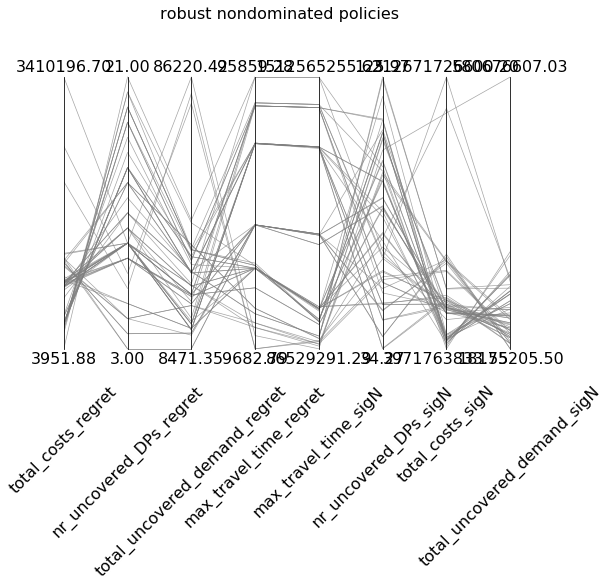

In [62]:
if len(robust_nondominated_policies) ==0:
    print("something went wrong")
elif len(robust_nondominated_policies) == 1:
    print(robust_nondominated_policies)
else:
    temp_cols = ["pol_i"]+list(all_robustness_scores.columns)

    df_temp = pd.DataFrame(robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

    plot_optimal(df_temp, all_robustness_scores.columns, "robust nondominated policies")

In [63]:
df_temp = df_temp[[
    'total_costs_regret', 'total_costs_sigN', 'nr_uncovered_DPs_regret',
    'nr_uncovered_DPs_sigN', 'total_uncovered_demand_regret',
    'total_uncovered_demand_sigN', 'max_travel_time_regret',
    'max_travel_time_sigN'
]]

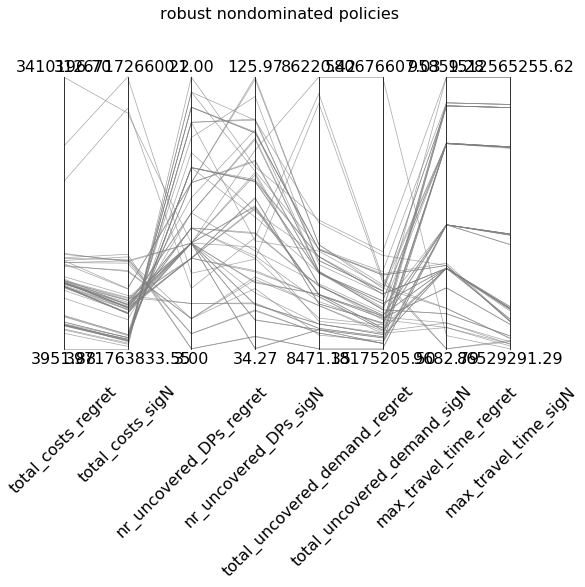

In [64]:
plot_optimal(df_temp, df_temp.columns, "robust nondominated policies")

In [65]:
np.asarray(robust_nondominated_policies)[:,0]

array(['12', '48', '51', '58', '93', '108', '123', '378', '383', '518',
       '533', '540', '544', '545', '548', '554', '569', '572', '575',
       '681', '1588', '1595', '1827', '1833', '1836', '1839', '1846',
       '1849', '1854', '1864', '1865', '1868', '1869', '1870', '1873',
       '1874', '1875', '1879', '1886', '1889', '1891', '1894', '1896',
       '1897', '1903', '1998', '2011', '2012', '2019', '2055', '2060',
       '2067', '2068', '2071', '2073', '2074', '2075', '3633', '4099',
       '4106'], dtype='<U18')

In [66]:
rob_nondom_i = np.asarray(robust_nondominated_policies)[:,0]

In [67]:
rob_nondom_pols = np.array(All_optional_pols)[rob_nondom_i.astype(int)]

In [68]:
import pickle

# Store data (serialize)
with open('{}/MOO/rob_nondom_pols_Full_Uncertainty.pickle'.format(case),
          'wb') as handle:
    pickle.dump(
        (rob_nondom_pols),
        handle,
        protocol=pickle.HIGHEST_PROTOCOL)

# Next iteration Framework